In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

In [ ]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(256, padding=8, padding_mode='edge'),
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

bird_data = get_bird_data()

torch.Size([8, 3, 256, 256])


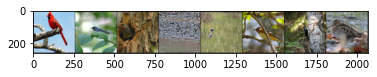

Labels:Northern Cardinal (Adult Male), Northern Parula, Northern Flicker (Red-shafted), Green Heron, Yellow-crowned Night-Heron (Adult), Bay-breasted Warbler (Breeding male), Hairy Woodpecker, Wilson's Snipe


In [ ]:
dataiter = iter(bird_data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % bird_data['to_name'][labels[j].item()] for j in range(8)))

In [ ]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=100, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    scaler = GradScaler()

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            with autocast():
              outputs = net(inputs)
              loss = criterion(outputs, labels)
            
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              scaler.update()

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

def accuracy(net, dataloader):
  net.to(device)
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for batch in dataloader:
          images, labels = batch[0].to(device), batch[1].to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return correct/total

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555)
resnet_losses = train(resnet, bird_data['train'], epochs=20, schedule={0:.01, 5:.001, 15:.0001}, checkpoint_path=checkpoints)
print("Training accuracy: %f" % accuracy(resnet, bird_data['train']))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Learning rate: 0.010000
[0,    10] loss: 6.478
[0,    20] loss: 6.332
[0,    30] loss: 6.162
[0,    40] loss: 5.992
[0,    50] loss: 5.789
[0,    60] loss: 5.570
[0,    70] loss: 5.433
[0,    80] loss: 5.197
[0,    90] loss: 4.997
[0,   100] loss: 4.833
[0,   110] loss: 4.681
[0,   120] loss: 4.552
[0,   130] loss: 4.300
[0,   140] loss: 4.254
[0,   150] loss: 4.095
[0,   160] loss: 3.933
[0,   170] loss: 3.876
[0,   180] loss: 3.721
[0,   190] loss: 3.662
[0,   200] loss: 3.553
[0,   210] loss: 3.452
[0,   220] loss: 3.344
[0,   230] loss: 3.293
[0,   240] loss: 3.250
[0,   250] loss: 3.118
[0,   260] loss: 3.021
[0,   270] loss: 2.987
[0,   280] loss: 2.942
[0,   290] loss: 2.898
[0,   300] loss: 2.813
[1,    10] loss: 2.669
[1,    20] loss: 2.578
[1,    30] loss: 2.486
[1,    40] loss: 2.559
[1,    50] loss: 2.386
[1,    60] loss: 2.368
[1,    70] loss: 2.317
[1,    80] loss: 2.323
[1,    90] loss: 2.280
[1,   100] loss: 2.207
[1,   110] loss: 2.177
[1,   120] loss: 2.164
[1,   130]

NameError: ignored

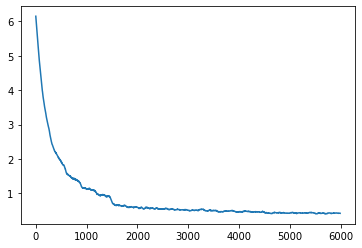

In [ ]:
plt.plot(smooth(resnet_losses, 50))

In [ ]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], bird_data['to_class'][predicted.item()]))
    out.close()

predict(model, data['test'], checkpoints + "preds.csv")